<a href="https://colab.research.google.com/github/MarshRey/DataScience315-HW10/blob/main/Copy_of_F24_DATASCI315_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER: MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

To copy the notebook, go to File and click create "Save a copy to ..." and work on that copy.

Please submit a pdf of the page of your notebook (Ctrl + p on the page, save as pdf, and submit that pdf) on gradescope.

Please remember to assign pages to the appropriate questions. Not doing so will result in the deduction of points. Please submit a **pdf** version of the colab notebook.

We will not rerun your uploaded notebook, so make sure to run each cell before downloading so that all outputs and plots are visible on the saved pdf.


## Question 0 Part 1
Do you have confusions or questions about the previous lectures?  (This is optional to answer)

(Answer here)

## Question 0 Part 2
Any suggestions or thoughts about the course? (This is optional to answer)

(Answer here)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
import pickle
import cv2

# Question 1 - Residual block implementation - (40 points)



An important aspect of deep learning is to convert a conceptual idea of neural network or a neural architecture into code. This motivates the idea of blocks. Many neural network models use many blocks (which are a collection of layers) to build the neural network. Let's further explore this idea.

---

Suppose we want to implement the following block

<img src='https://drive.google.com/uc?id=1Eu6XK96JwDJA0r_qBDkmpU5IihSJQYja' width = 400>

I would write the following code to implement this block. And this block can be used a building blocks for a complex neural network.

In [ ]:
class ExampleBlock(keras.Model):
  def __init__(self):
    super(ExampleBlock, self).__init__()
    self.dense1 = layers.Dense(64, activation='relu',
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))
    self.dense2 = layers.Dense(64, activation = "relu",
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))

  def call(self, x):
    weighted_x = self.dense1(x)
    weighted_x = self.dense2(weighted_x)
    return weighted_x

In [ ]:
blk = ExampleBlock()
X = tf.random.normal((1, 32, 32, 3))
Y = blk(X)
Y.shape

TensorShape([1, 32, 32, 64])

Similarly, using the following flowchart, fill in the ```__init__()``` and ```call()``` for the ResidualBlock class

<img src='https://drive.google.com/uc?id=1P5nKQUh3IA-yGFScOtt9oJb9pTTmB3rC' width = 400>

The left flowchart is the ResidualBlock Architecture for when ``` self_conv = False ``` and the right flowchart is when ```self_conv = True```. ```filters``` is a list of filters for the respective convolutional layers.


In the flowchart, we can see a batch normalization layer. This layer is added to make training faster and more stable by recentering and rescaling the network inputs.

Please remember to set ```kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100)``` in your Convolutional layers to make the results reproducible.

Here is some pseudocode for the ```__init__``` function. __PLEASE__ keep in mind that this is just pseudocode and this may not compile as is. This pseudocode is supposed to help you understand how to approach the problem logically. I have left out some layers from this pseudocode so there is still some code that needs to be written for your ```__init__``` function to work as intended.
```
def __init__(filters, self_conv):
    self.__convolved = self_conv
    strides = [1, 1]
    if self_conv:
      strides = [2, 1]
    self.conv1 = conv(filters = filters[0],kernel_size=3, strides = strides[0])
    self.conv2 = conv(filters = filters[1], kernel_size=3, strides = strides[1])
    if self_conv:
      self.conv3 = conv(filters = filters[2], kernel_size=1, strides = strides[0])

```



In [ ]:
tf.random.set_seed(100)

class ResidualBlock(keras.Model):
  def __init__(self, filters, self_conv):
    super(ResidualBlock, self).__init__()
    self.__convolved = self_conv
    strides = [1, 1]
    if self_conv:
      strides = [2, 1]
    self.conv1 = layers.Conv2D(filters = filters[0],kernel_size=3, strides = strides[0], padding='same',
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))
    self.bn1 = layers.BatchNormalization()
    self.relu1 = layers.ReLU()
    self.conv2 = layers.Conv2D(filters = filters[1], kernel_size=3, strides = strides[1], padding='same',
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100),)
    self.bn2 = layers.BatchNormalization()
    if self_conv:
      self.conv3 = layers.Conv2D(filters = filters[1], kernel_size=1, strides = strides[0], padding='same',
                        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))

    self.relu2 = layers.ReLU()

  def call(self, x):
    residual = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.__convolved:
      residual = self.conv3(residual)

    x += residual
    x = self.relu2(x)
    return x


X = np.ones((1, 32, 32, 3))
block_2 = ResidualBlock([16, 3], False)
Y_2 = block_2(X)
print(tf.shape(Y_2))
print(Y_2[0, 0, 0])

block_3 = ResidualBlock([16, 3, 3], True)
Y_3 = block_3(X)
print(tf.shape(Y_3))
print(Y_3[0, 0, 0])

tf.Tensor([ 1 32 32  3], shape=(4,), dtype=int32)
tf.Tensor([1.105336  1.0558189 1.1299278], shape=(3,), dtype=float32)
tf.Tensor([ 1 16 16  3], shape=(4,), dtype=int32)
tf.Tensor([0.29695478 0.         0.10192551], shape=(3,), dtype=float32)


# Question 2 - ResNet18 Implementation (60 points)

ResNet or Residual Network is a very popular Convolutional Neural network. It uses the concept of skip connections (as seen in Question 2) which adds the input with the output when the input goes through a bunch of convolutonal layers. This addition is key when some of the higher layers don't produce anything meaningful, the lower layers in the architechture still have a chance to perform well with the input. So, say the input passes through some convolutional layers and the output is 0. By adding the input back, we are giving the next convolutional layers some meaningful input.

In this question, you will be asked to build ResNet18 which contains 18 convolutonal layers in total. You will be using the Cifar10 dataset to train the model. This dataset contains 60,000 32*32 color images (so it has 3 channels). These are the classes in the dataset - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

In [ ]:
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

(X_train_old, Y_train_old), (X_test_old, Y_test_old) = cifar10.load_data()

In [ ]:
X_train = X_train_old.astype('float32')
X_test = X_test_old.astype('float32')
print(X_train.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train_old, test_size=0.2, random_state=42)
encoder = OneHotEncoder()
encoder.fit(Y_train_old)

Y_train = encoder.transform(y_train).toarray()
Y_val = encoder.transform(y_val).toarray()

Y_test = encoder.transform(Y_test_old).toarray()


print(Y_train.shape)

(50000, 32, 32, 3)
(40000, 10)


## Part (a) Data Augmentation (20 points)

Before starting to train the ResNet Model, we need to make some modifications to our images. Data Augmentation is a great way to prevent overfitting. We also need to rescale the model to have the pixels be between 0 and 1. Create a sequential model that has 3 layers - a layer that does random horizontal flips, a layer that does random rotations of factor 0.2, and a layer that rescales the images accordingly.

Please remember to set the seed argument to 100 for the Random layers.

In [ ]:
data_aug_preprocess = tf.keras.Sequential([layers.RandomFlip('horizontal', seed=100),
                                          layers.RandomRotation(0.2, seed=100),
                                          layers.Rescaling(1/255)]
)

## Part (b) Filling in ResNet18 Class (40 points)
Use the following flowchart and ResidualBlock class from Question 1 to implement ResNet18

<img src='https://drive.google.com/uc?id=1y6DHU48iu54YAeg7ywx7_3zyZKHnbsdY' width = 700>

The "Skip Connection" parts are the ResidualBlocks where ```self_conv = True```. As we can see from the output layer of this flowchart, this network is for a problem with 1000 outputs. Please remember to swap that output layer out with an appropriate output layer for an image classification problem with ```num_classes``` number of outputs. ```data_aug``` will take the sequential model with the data augmentation and preprocessing layers

Please remember to set ```kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100)``` in your Convolutional layers and dense layers to make the results reproducible.

Make sure to go to "Edit" > "Notebook Settings" and select "GPU" before running the next few code chunks.


Here is some pseudocode for the ```__init__``` function. __PLEASE__ keep in mind that this is just pseudocode and this may not compile as is. It's also an incomplete implementation as I have only included code for a few blocks. This pseudocode is supposed to help you understand how to approach the problem logically. There is still some code that needs to be written for your ```__init__``` function to work.
```
def __init__(filters, num_classes, input_shape, data_aug):
  self.da = data_aug
  self.conv1 = conv(filters = 64, kernel_size = 7, strides=2, input_shape = input_shape)
  self.before_res_block_bn = batchnorm()
  self.maxpooling = maxpool(pool_size=(2, 2), strides=2, padding="same")
  self.resnetblock_1 = ResidualBlock([64, 64], False) # This is the ResidualBlock from the previous question
  ...
  # The rest is left to you to implement

```



In [ ]:
class ResNet18(keras.Model):
  def __init__(self, num_classes, input_shape, data_aug):
    super(ResNet18, self).__init__()
    self.da = data_aug

    self.conv1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=input_shape,
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))

    self.before_res_block_bn = layers.BatchNormalization()
    self.maxpool =  layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')

    self.resnetblock_1 = ResidualBlock([64, 64], False)
    self.resnetblock_2 = ResidualBlock([64, 64], False)

    self.resnetblock_3 = ResidualBlock([128, 128], True)
    self.resnetblock_4 = ResidualBlock([128, 128], False)

    self.resnetblock_5 = ResidualBlock([256, 256], True)
    self.resnetblock_6 = ResidualBlock([256, 256], False)

    self.resnetblock_7 = ResidualBlock([512, 512], True)
    self.resnetblock_8 = ResidualBlock([512, 512], False)

    self.avgpool = layers.GlobalAveragePooling2D()
    self.out = layers.Dense(num_classes, activation='softmax',
                            kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))

  def call(self, x):
    x = self.da(x)

    x = self.conv1(x)
    x = self.before_res_block_bn(x)
    x = self.maxpool(x)

    x = self.resnetblock_1(x)
    x = self.resnetblock_2(x)

    x = self.resnetblock_3(x)
    x = self.resnetblock_4(x)

    x = self.resnetblock_5(x)
    x = self.resnetblock_6(x)

    x = self.resnetblock_7(x)
    x = self.resnetblock_8(x)

    x = self.avgpool(x)
    x = self.out(x)
    return x



In [ ]:
resnet_model = ResNet18(10, (None, 32, 32, 3), data_aug_preprocess)
resnet_model.compile(optimizer= "adam",
                     loss="categorical_crossentropy",
                     metrics=["categorical_crossentropy", "accuracy"])
history = resnet_model.fit(X_train, Y_train, batch_size = 256, steps_per_epoch = len(X_train) // 256, epochs = 10,
                 validation_data = (X_val, Y_val))

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.3220 - categorical_crossentropy: 1.9786 - loss: 1.9786 - val_accuracy: 0.4384 - val_categorical_crossentropy: 1.5505 - val_loss: 1.5505
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4688 - categorical_crossentropy: 1.4377 - loss: 1.4377 - val_accuracy: 0.4441 - val_categorical_crossentropy: 1.5572 - val_loss: 1.5572
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4576 - categorical_crossentropy: 1.5069 - loss: 1.5069 - val_accuracy: 0.4998 - val_categorical_crossentropy: 1.3972 - val_loss: 1.3972
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5156 - categorical_crossentropy: 1.2169 - loss: 1.2169 - val_accuracy: 0.4968 - val_categorical_crossentropy: 1.4056 - val_loss: 1.4056
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5061 - categorical_crossentropy: 1.3677 - loss: 1.3677 - val_accuracy: 0.5317 - val_categorical_crossentropy: 1.3053 - v

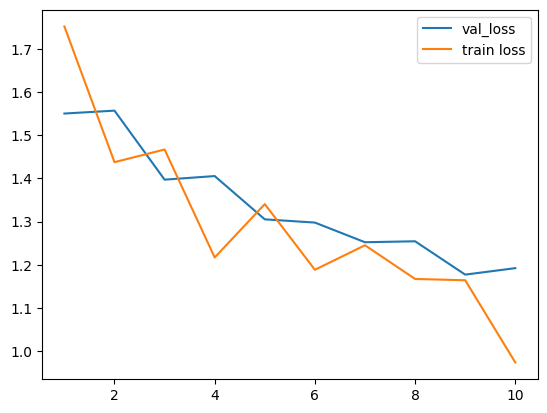

In [ ]:
val_loss_q3 = history.history["val_categorical_crossentropy"]
train_loss_q3 = history.history["categorical_crossentropy"]
plt.plot(np.arange(1,len(val_loss_q3)+1),val_loss_q3, label="val_loss")
plt.plot(np.arange(1,len(train_loss_q3)+1),train_loss_q3, label="train loss")
plt.legend()